<a href="https://colab.research.google.com/github/Jaztin-F/ITBAN3/blob/main/Laboratory_5_Francisco_Belbelone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Set Up**

In [38]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import drive

# **Download and explore the dataset**

In [39]:
# Mounting Google Drive to access files
drive.mount('/content/drive')

# Defining the URL of the dataset directory on Google Drive
dataset_url = "/content/drive/MyDrive/Francisco | Colab Notebooks/Datasets/Train"

# Creating a Path object for the dataset directory
data_dir = pathlib.Path(dataset_url).with_suffix('')

# Counting the total number of images in the dataset
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
50


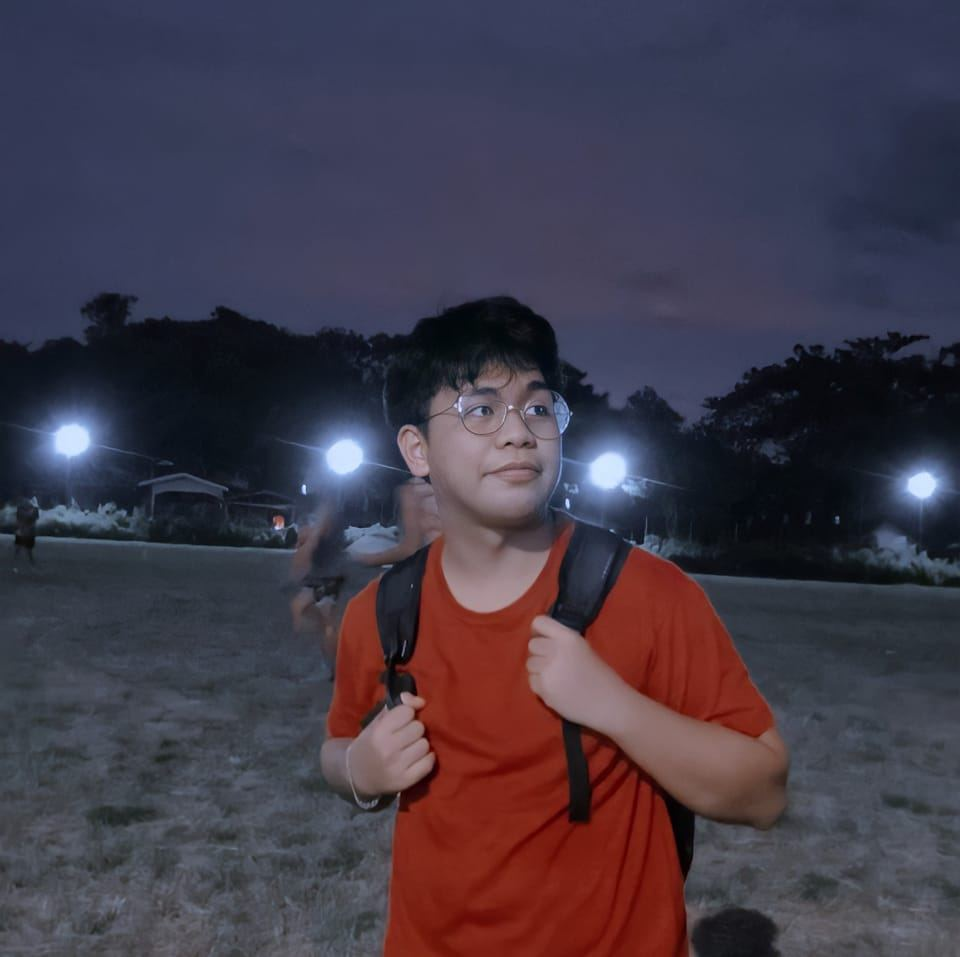

In [40]:
# Listing files in the 'Justine' directory
Justine = list(data_dir.glob('Justine/*'))

# Opening the second image in the 'Justine' directory using PIL
PIL.Image.open(str(Justine[1]))

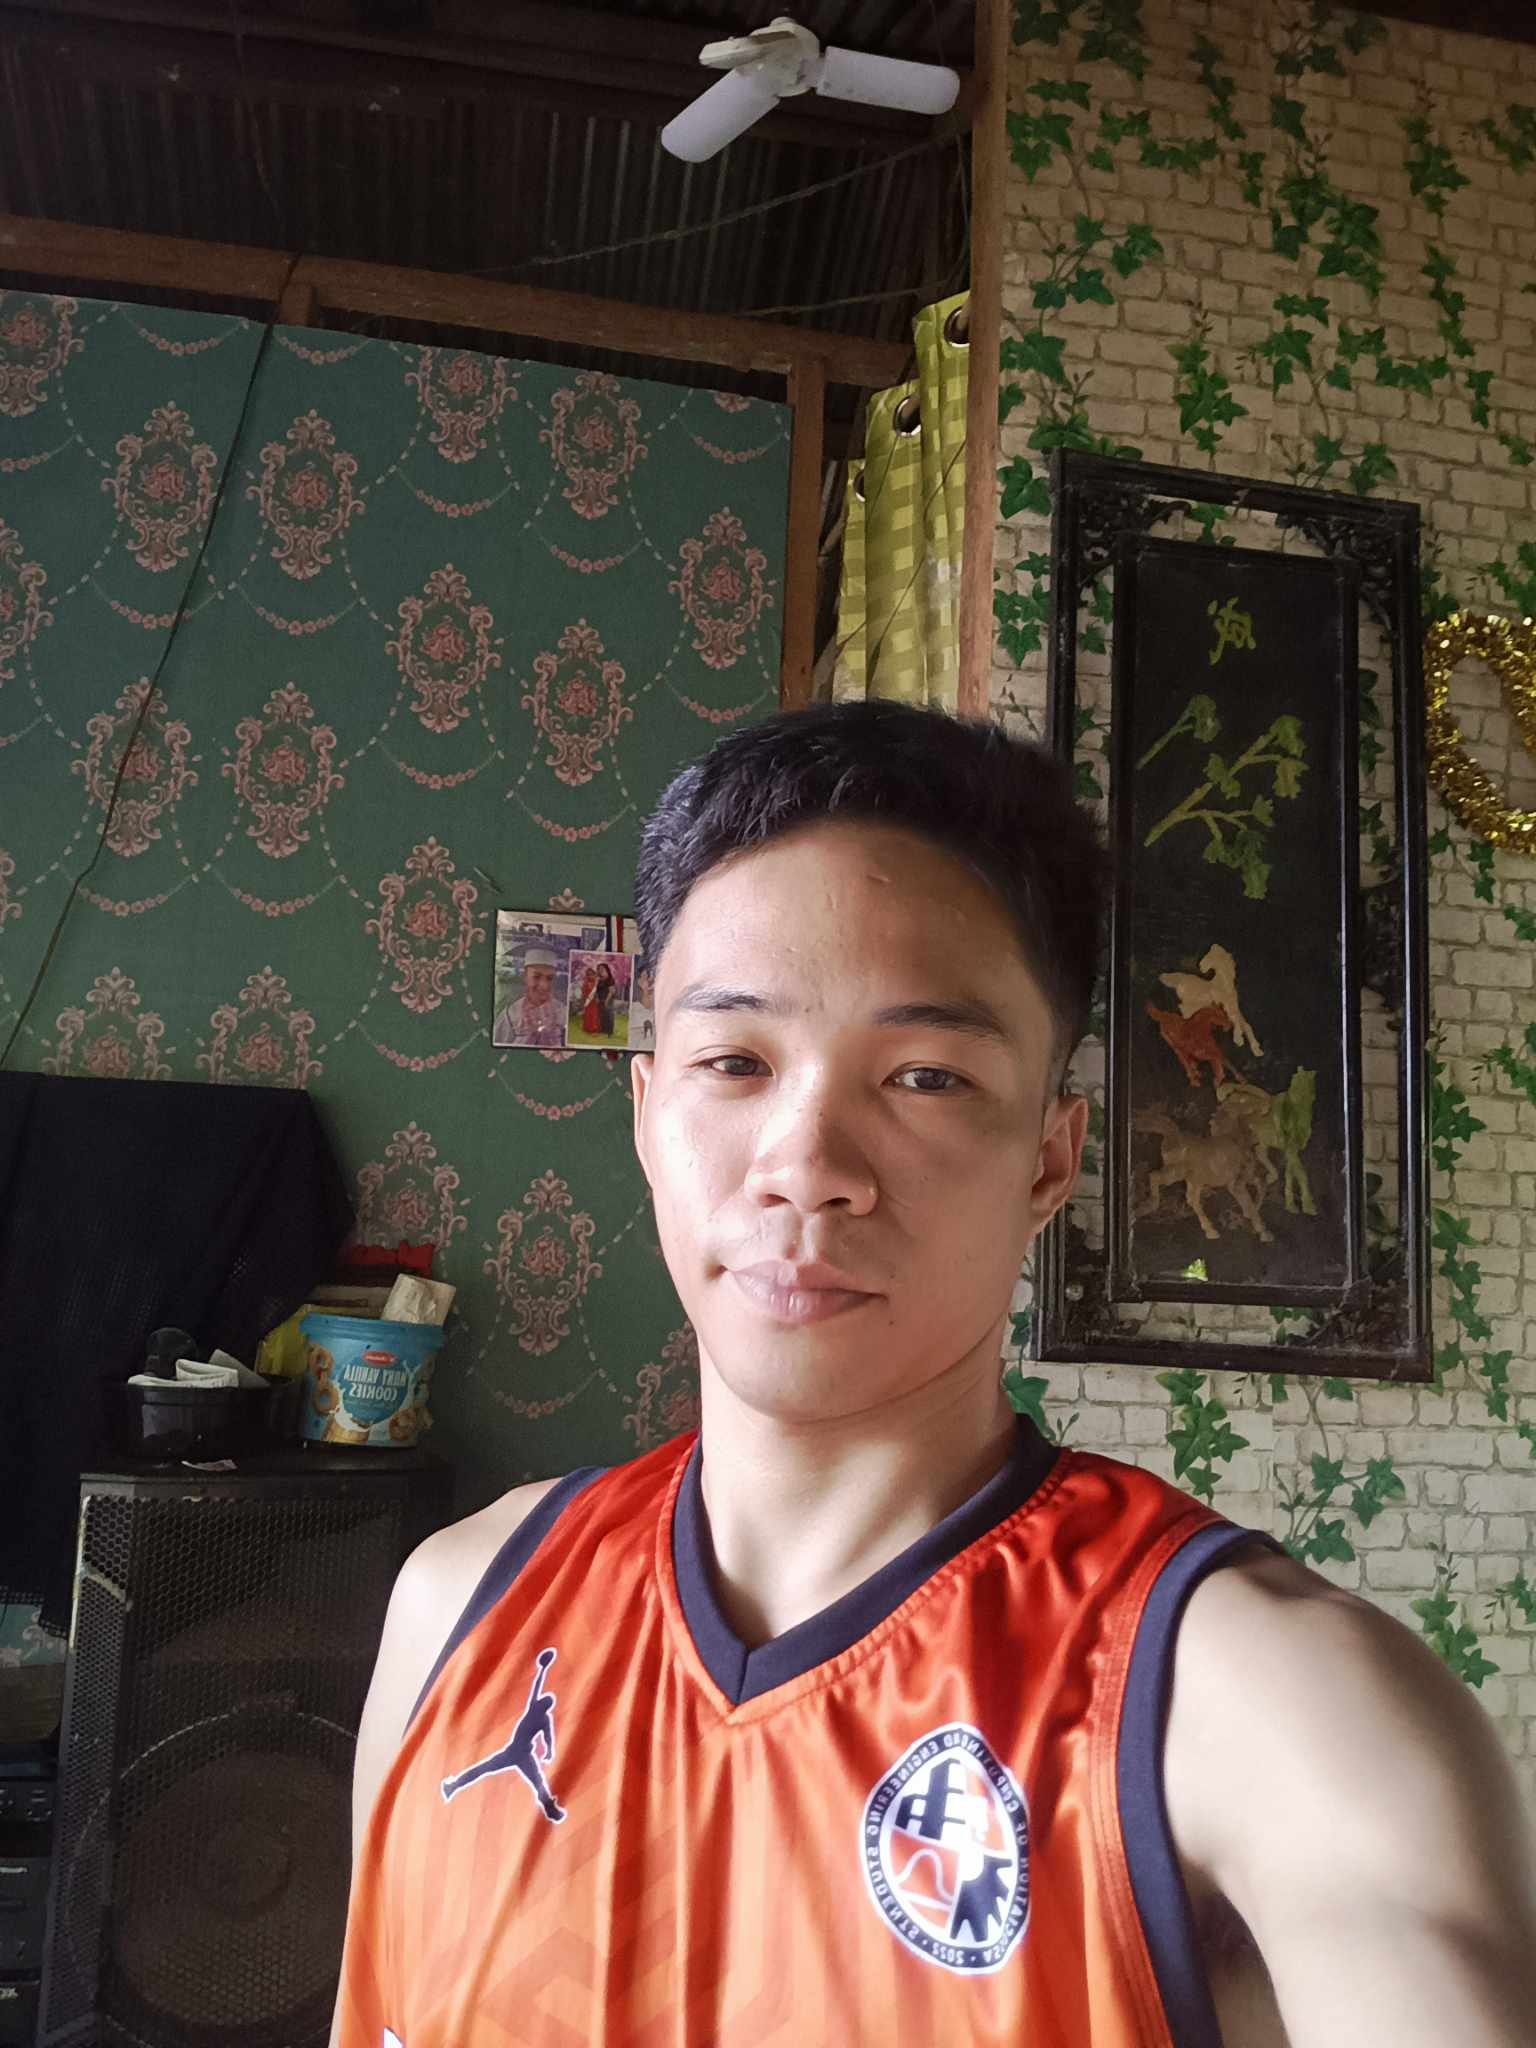

In [41]:
# Creating a list of file paths for all files in the 'Bonjovie' directory
Bonjovie = list(data_dir.glob('Bonjovie/*'))

# Opening and displaying the first image in the 'Bonjovie' directory using PIL
PIL.Image.open(str(Bonjovie[0]))

# **Create a dataset**

In [42]:
# Setting the batch size for training
batch_size = 32

# Defining the height of the images
img_height = 180

# Defining the width of the images
img_width = 180

In [43]:
# Creating a training dataset from directory using specified parameters
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 50 files belonging to 2 classes.
Using 40 files for training.


In [44]:
# Creating a validation dataset from directory using specified parameters
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 50 files belonging to 2 classes.
Using 10 files for validation.


In [45]:
# Accessing the class names from the training dataset
class_names = train_ds.class_names

# Printing the class names
print(class_names)


['Bonjovie', 'Justine']


# **Visualize the data**

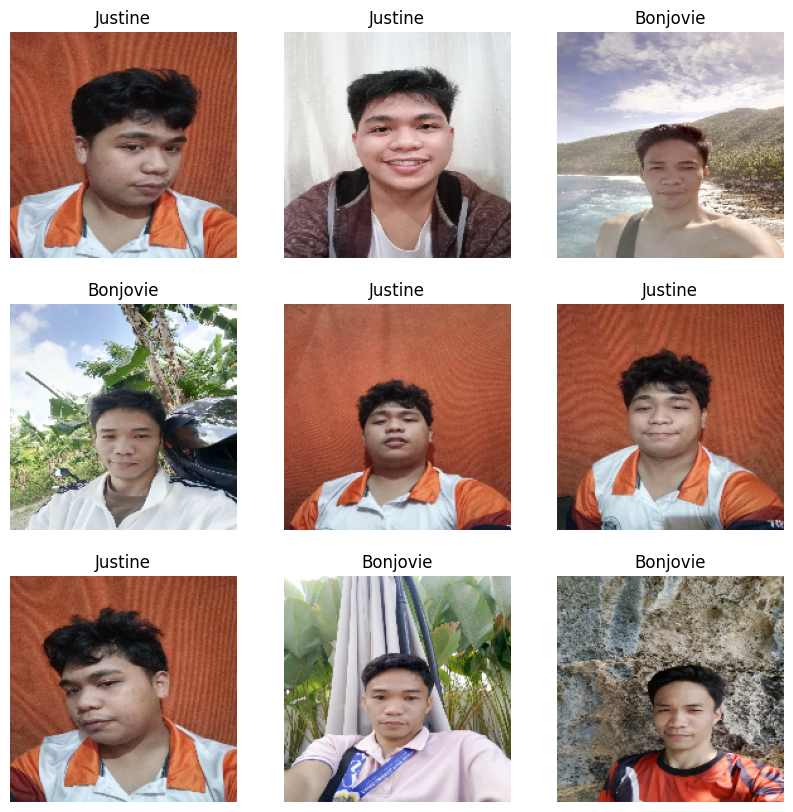

In [46]:
# Creating a figure for plotting with a specific size
plt.figure(figsize=(10, 10))

# Iterating over the first batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
    # Plotting 9 images with their corresponding labels
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # Displaying the image
        plt.imshow(images[i].numpy().astype("uint8"))
        # Adding title with the corresponding label
        plt.title(class_names[labels[i]])
        plt.axis("off")  # Turning off axis

In [47]:
# Iterating over batches of images and labels from the training dataset
for image_batch, labels_batch in train_ds:
    # Printing the shape of the image batch
    print(image_batch.shape)
    # Printing the shape of the labels batch
    print(labels_batch.shape)
    break  # Exiting the loop after printing the first batch


(32, 180, 180, 3)
(32,)


# **Configure the dataset for performance**

In [48]:
# Setting AUTOTUNE value for buffer size optimization
AUTOTUNE = tf.data.AUTOTUNE

# Caching, shuffling, and prefetching the training dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Caching and prefetching the validation dataset
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# **Standardize the data**

In [49]:
# Defining a Rescaling layer for normalization
normalization_layer = layers.Rescaling(1./255)

In [50]:
# Applying the normalization layer to the training dataset using map
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# Extracting a batch of images and labels from the normalized dataset
image_batch, labels_batch = next(iter(normalized_ds))

# Extracting the first image from the batch
first_image = image_batch[0]

# Printing the minimum and maximum pixel values of the first image
# Notice that the pixel values are now normalized to [0,1]
print(np.min(first_image), np.max(first_image))

0.0 1.0


# **Data augmentation**

In [51]:
# Number of classes (number of categories or labels)
num_classes = len(class_names)

# Creating a Sequential model with the specified layers
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# **Compile the model**

In [52]:
# Compiling the model with specified optimizer, loss function, and metrics
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# **Model summary**

In [53]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

# **Train the model**

In [54]:
# Number of epochs for training
epochs = 10

# Training the model and storing the training history
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
2/2 [==============================] - 3s 705ms/step - loss: 0.6652 - accuracy: 0.6500 - val_loss: 2.3080 - val_accuracy: 0.6000
Epoch 2/10
2/2 [==============================] - 1s 383ms/step - loss: 2.0723 - accuracy: 0.6000 - val_loss: 1.6533 - val_accuracy: 0.4000
Epoch 3/10
2/2 [==============================] - 1s 1s/step - loss: 1.5088 - accuracy: 0.5250 - val_loss: 1.2290 - val_accuracy: 0.4000
Epoch 4/10
2/2 [==============================] - 1s 1s/step - loss: 0.6637 - accuracy: 0.5250 - val_loss: 0.5086 - val_accuracy: 0.8000
Epoch 5/10
2/2 [==============================] - 2s 2s/step - loss: 0.4025 - accuracy: 0.9250 - val_loss: 0.3936 - val_accuracy: 1.0000
Epoch 6/10
2/2 [==============================] - 2s 343ms/step - loss: 0.3723 - accuracy: 0.9750 - val_loss: 0.2662 - val_accuracy: 1.0000
Epoch 7/10
2/2 [==============================] - 1s 984ms/step - loss: 0.3575 - accuracy: 0.9000 - val_loss: 0.2385 - val_accuracy: 1.0000
Epoch 8/10
2/2 [=============

# **Visualize training results**

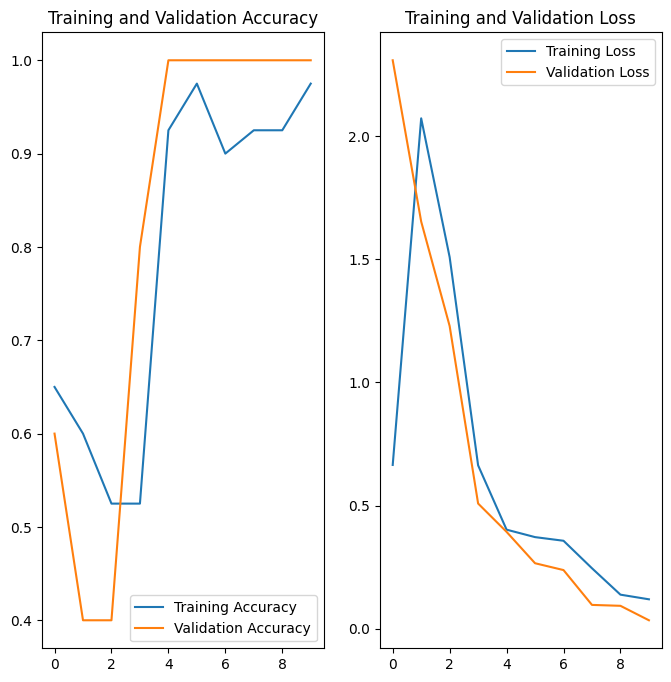

In [55]:
# Extracting training and validation accuracy from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extracting training and validation loss from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Generating the range of epochs for plotting
epochs_range = range(epochs)

# Plotting training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [56]:
# Defining a Sequential model for data augmentation
data_augmentation = keras.Sequential([
    # Randomly flip the input horizontally
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    # Randomly rotate the input images by a fraction of 0.1
    layers.RandomRotation(0.1),
    # Randomly zoom into the input images by a fraction of 0.1
    layers.RandomZoom(0.1),
])

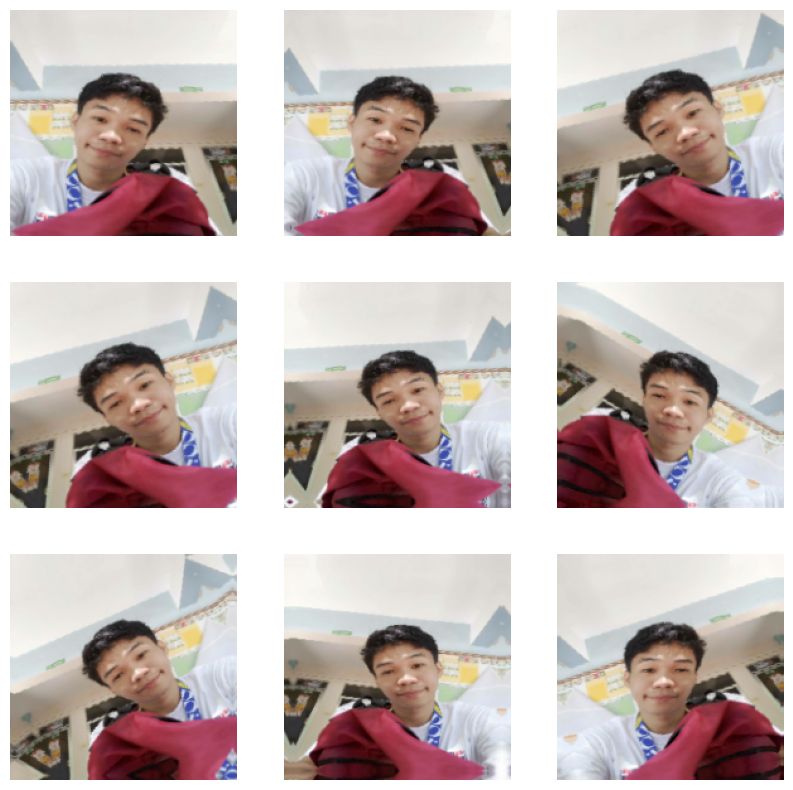

In [57]:
# Creating a figure for plotting with a specific size
plt.figure(figsize=(10, 10))

# Iterating over the first batch of images from the training dataset
for images, _ in train_ds.take(1):

    # Applying data augmentation to the images
    for i in range(9):
        augmented_images = data_augmentation(images)

        # Creating subplots for augmented images
        ax = plt.subplot(3, 3, i + 1)

        # Displaying the augmented images
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# **Sequential Model**

In [58]:
# Creating a Sequential model with the specified layers
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [59]:
# Compiling the model with specified optimizer, loss function, and metrics

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [60]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

In [61]:
# Number of epochs for training
epochs = 15

# Training the model and storing the training history
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
2/2 [==============================] - 4s 1s/step - loss: 0.5953 - accuracy: 0.6500 - val_loss: 8.8536 - val_accuracy: 0.4000
Epoch 2/15
2/2 [==============================] - 3s 843ms/step - loss: 6.4492 - accuracy: 0.5250 - val_loss: 1.1773 - val_accuracy: 0.6000
Epoch 3/15
2/2 [==============================] - 1s 373ms/step - loss: 1.3988 - accuracy: 0.4750 - val_loss: 0.3879 - val_accuracy: 0.9000
Epoch 4/15
2/2 [==============================] - 2s 1s/step - loss: 0.6741 - accuracy: 0.5500 - val_loss: 0.8378 - val_accuracy: 0.4000
Epoch 5/15
2/2 [==============================] - 1s 1s/step - loss: 0.7351 - accuracy: 0.5250 - val_loss: 0.6952 - val_accuracy: 0.4000
Epoch 6/15
2/2 [==============================] - 1s 443ms/step - loss: 0.6235 - accuracy: 0.5250 - val_loss: 0.4818 - val_accuracy: 0.9000
Epoch 7/15
2/2 [==============================] - 2s 2s/step - loss: 0.4278 - accuracy: 0.9000 - val_loss: 0.3759 - val_accuracy: 1.0000
Epoch 8/15
2/2 [================

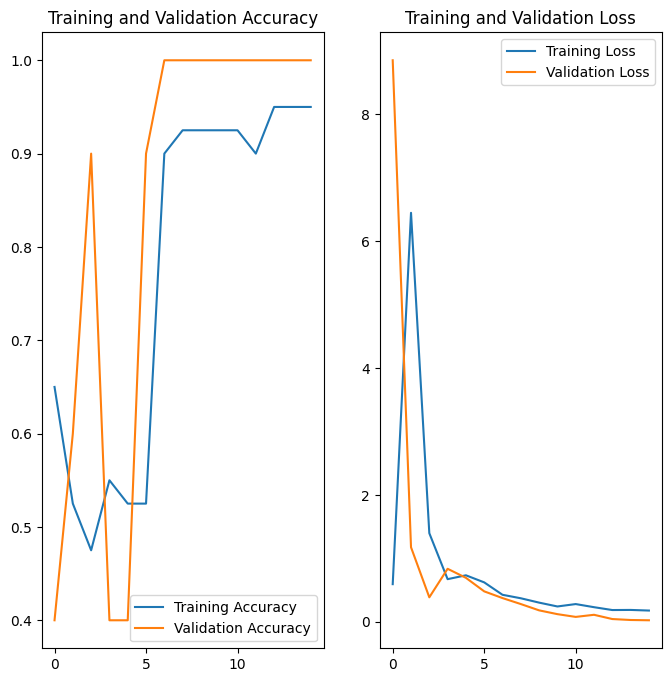

In [63]:
# Extracting training and validation accuracy from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extracting training and validation loss from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Generating the range of epochs for plotting
epochs_range = range(epochs)

# Plotting training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# **Testing Data**

In [72]:
# Define image paths as a list
drive_img_paths = [
    "/content/drive/MyDrive/Francisco | Colab Notebooks/Datasets/Test/Bonjovie.jpg",  # Bonjovie Test Image
    "/content/drive/MyDrive/Francisco | Colab Notebooks/Datasets/Test/Justine.jpg",   # Justine Test Image
    "/content/drive/MyDrive/Francisco | Colab Notebooks/Datasets/Test/Unkown Person.jpg"  # Unknown Person Test Image
]

# Iterate over each image path
for drive_img_path in drive_img_paths:
    # Load the image from the local file path
    img = tf.keras.utils.load_img(drive_img_path, target_size=(img_height, img_width))

    # Convert the image to an array and add batch dimension
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Perform predictions using the model
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    # Get the predicted class index
    predicted_class_index = np.argmax(score)

    print(class_names)

    # Check if the predicted class index is within the range of class_names
    if predicted_class_index < len(class_names):
        # Get the predicted class name
        class_name = class_names[predicted_class_index]
        # Print the predicted class and confidence score
        print("This image most likely is {} with a {:.2f} percent confidence.\n"
              .format(class_name, 100 * np.max(score)))
    else:
        print("Error: Predicted class index is out of range.")

1/1 [==============================] - 0s 69ms/step
['Bonjovie', 'Justine']
This image most likely is Bonjovie with a 87.40 percent confidence.

1/1 [==============================] - 0s 30ms/step
['Bonjovie', 'Justine']
This image most likely is Justine with a 98.95 percent confidence.

1/1 [==============================] - 0s 39ms/step
['Bonjovie', 'Justine']
This image most likely is Bonjovie with a 81.34 percent confidence.

